<a href="https://colab.research.google.com/github/JoeOlang/NLP/blob/main/Text%20Classification/Swahili/ZindiNews/v1.6_LinearSVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [3]:
# Introduce some common Swahili stop words
stop_words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/swahili_stopwords.csv')
stop_words = stop_words_df['StopWords'].tolist()

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Train.csv')
df.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [5]:
df['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)



---

In [6]:
# Percentage of news with text
total = df['content'].notnull().sum()
round((total/len(df)*100),1)

100.0

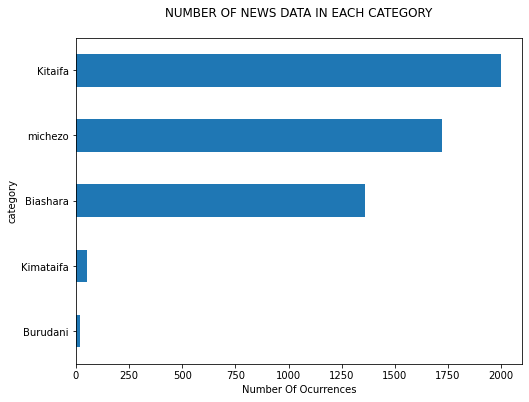

In [7]:
# The bar chart to show the number of news per category
fig = plt.figure(figsize=(8,6))
df.groupby('category').content.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF NEWS DATA IN EACH CATEGORY\n')
plt.xlabel('Number Of Ocurrences', fontsize = 10);
plt.savefig('category_graph.png', bbox_inches='tight')

In [8]:
# clean text
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        
        return: modified string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(" \d+", " ", text) # remove digits
    text = re.sub(" #\d+", " ", text) # remove digits starting with # symbol
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)
df.head(10)

,id,content,category
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha liki...,Biashara
2,SW10,serikali imetoa miezi sita taasisi zote umma a...,Kitaifa
3,SW100,kampuni mchezo kubahatisha mbet imeingia makub...,michezo
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu ...,Kitaifa
5,SW1002,malkia mipasho afrika mashariki khadija omary ...,michezo
6,SW1003,meneja masoko mawasiliano taasisi ngula cheyo ...,Biashara
7,SW1004,idadi vifo waendesha bodaboda nchini vitokanav...,Kitaifa
8,SW1006,uzinduzi rais amesema kuna haja kutafuta majaw...,Biashara
9,SW1007,mshindi mchezo utakaozikutanisha tottenham roc...,michezo


In [9]:
# Create a new column 'label_id' with encoded categories 
df['label_id'] = df['category'].factorize()[0]
new_df = df[['category', 'label_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['label_id', 'category']].values)

# New dataframe
df.head()

,id,content,category,label_id
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha liki...,Biashara,1
2,SW10,serikali imetoa miezi sita taasisi zote umma a...,Kitaifa,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makub...,michezo,2
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu ...,Kitaifa,0


In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words=stop_words)

# We transform each news data into a vector
features = tfidf.fit_transform(df.content).toarray()
labels = df.label_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 5151 news data is represented by 34258 features (TF-IDF score of unigrams and bigrams)


In [13]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==>  Biashara :
  * Most Correlated Unigrams are: benki, bidhaa, wateja
  * Most Correlated Bigrams are: huduma kibenki, fursa biashara, wateja wetu

==>  Burudani :
  * Most Correlated Unigrams are: mrembo, up, brown
  * Most Correlated Bigrams are: ameipongeza kampuni, kumi bora, haki wanawake

==>  Kimataifa :
  * Most Correlated Unigrams are: virusi, maombolezo, trump
  * Most Correlated Bigrams are: kufuatia kifo, mamlaka nchi, nchini malawi

==>  Kitaifa :
  * Most Correlated Unigrams are: ligi, timu, mchezo
  * Most Correlated Bigrams are: rais john, rais magufuli, ligi kuu

==>  michezo :
  * Most Correlated Unigrams are: ligi, timu, mchezo
  * Most Correlated Bigrams are: uwanja taifa, timu taifa, ligi kuu


In [14]:
X = df['content'] # collection of news data
y = df['category'] # labels(i.e.,for the 4 different news categories)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
print("shape of x_train set :", X_train.shape)
print("shape of y_train set :",y_train.shape)
print("shape of x_test set :",X_test.shape)
print("shape of y_test set :",y_test.shape)

shape of x_train set : (3863,)
shape of y_train set : (3863,)
shape of x_test set : (1288,)
shape of y_test set : (1288,)


In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.869928,0.008002
LogisticRegression,0.862745,0.007406
MultinomialNB,0.810718,0.010381
RandomForestClassifier,0.660845,0.013280


In [17]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATIION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['category'].unique()))

			CLASSIFICATIION REPORT

              precision    recall  f1-score   support

     Kitaifa       0.84      0.86      0.85       510
    Biashara       0.84      0.82      0.83       343
     michezo       0.94      0.97      0.96       415
   Kimataifa       0.50      0.06      0.11        17
    Burudani       1.00      0.33      0.50         3

    accuracy                           0.87      1288
   macro avg       0.82      0.61      0.65      1288
weighted avg       0.87      0.87      0.87      1288



In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8726708074534162


Text(0.5, 1.0, 'CONFUSION MATRIX - Logistic Regression\n')

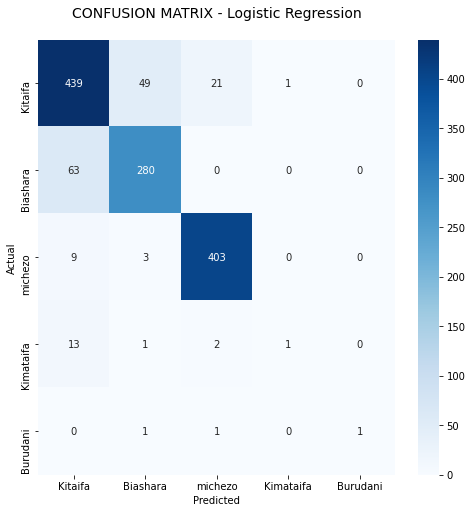

In [20]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.category.values, 
            yticklabels=new_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=14)

In [22]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 
                                                                'content']])
            print('')

actual class 'Biashara' predicted as 'Kitaifa' : 63 examples.


,category,content
2097,Biashara,rais john magufuli leo anakutana wafanyabiasha...
1264,Biashara,waziri mkuu kassim majaliwa ameitaka wizara ki...
3722,Biashara,kipindi mwaka mmoja kufikia desemba mwaka jana...
3251,Biashara,hayo yalibainishwa mwishoni wiki waziri fedha ...
4557,Biashara,mpango uliopewa jina kili challenge unadhamini...
...,...,...
4107,Biashara,waziri huyo aliyeongozana waziri maji umwagili...
921,Biashara,nchemba aliyasema hayo mwishoni wiki bungeni m...
3278,Biashara,ameyasema hayo dar es salaam kongamano siku ku...
3077,Biashara,mujibu momgela ongezeko wafanyabiashara jiji a...



actual class 'Kitaifa' predicted as 'Biashara' : 49 examples.


,category,content
1141,Kitaifa,waziri madini angellah kairuki amesema wizara ...
678,Kitaifa,meneja mamlaka usimamizi bima tira kanda stell...
2905,Kitaifa,waziri habari utamaduni sanaa michezo dk harri...
4479,Kitaifa,msimu kuelekea krismasi mwaka mpya wafanyabias...
4538,Kitaifa,kuhakikisha magazeti habarileo spotileo daily ...
440,Kitaifa,rais zanzibar dk ali mohamed shein amesema kut...
4303,Kitaifa,rais john magufuli anatarajiwa mgeni rasmi kil...
4040,Kitaifa,waziri mkuu kassim majaliwa ameutaka mkoa tabo...
1379,Kitaifa,wizara maliasili utalii imeunda kamati yenye j...
473,Kitaifa,wananchi vijiji kitongosima shinembo wilaya ma...



actual class 'Kitaifa' predicted as 'michezo' : 21 examples.


,category,content
4017,Kitaifa,timu taifa afrika car mbili ilitoka nyuma kuil...
2229,Kitaifa,nigeria imetangaza majina wachezaji ajili fain...
4242,Kitaifa,naibu waziri habari utamaduni sanaa michezo ju...
2720,Kitaifa,kinara ligi kuu tanzania bara tpl yanga amepan...
984,Kitaifa,kikosi mabingwa soka tanzania bara simba jana ...
3689,Kitaifa,mbio ubingwa ligi kuu bara vigogo ligi yanga a...
1848,Kitaifa,kuelekea kilele tamasha tigo fiesta kesho wasa...
1960,Kitaifa,klabu azam fc imewatema nyota wanane kikosi ms...
372,Kitaifa,mwanaume kijiji obama jimbo migori nchini keny...
1299,Kitaifa,msanii muziki nchini richard mavoko amekanusha...


In [ ]:
'''
# save the model
model_filename = open('finalized_model.sav', 'wb')
pickle.dump(model, model_filename)
model_filename.close()
# save fitted vectorizer to use for the prediction time
tf_idf_output = open('fitted_vectorizer.pickle', 'wb')
pickle.dump(fitted_vectorizer, tf_idf_output)
tf_idf_output.close()
# save the dictionaries
output1 = open('category_to_id.pkl', 'wb')
pickle.dump(category_to_id, output1)
output1.close()
output2 = open('id_to_category.pkl', 'wb')
pickle.dump(id_to_category, output2)
output2.close()
'''



---



Unpacking dftest['scores']

In [ ]:
dftest[['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani']] = pd.DataFrame(dftest.scores.tolist())

In [ ]:
dftest = dftest.drop(columns=['content', 'scores'])

In [ ]:
dftest.to_csv(r'/content/drive/MyDrive/Colab Notebooks/NLP/Submission2.csv', index = False)